# AltaML Technical Task

In this notebook, we will be exploring the problem given by AltaML and answer some of the questions provided. Let us first begin by creating a cell to import all the packages that will be used in this project:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.impute import KNNImputer

import statsmodels.api as sm
from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import sklearn
print(sklearn.__version__)

0.24.2


# Section 1: Cleaning Data

Let's take a first look at the data:

In [3]:
# Import data and show the first 5 rows
data = pd.read_csv('dataset.csv')
data.head()

,id,water,uv,area,fertilizer_usage,yield,pesticides,region,categories
0,169,5.615,65.281,3.230,0,7.977,8.969,0,"b,a,c"
1,476,7.044,73.319,9.081,0,23.009,7.197,0,"c,a,d"
2,152,5.607,60.038,2.864,2,23.019,7.424,0,"d,a"
3,293,9.346,64.719,2.797,2,28.066,1.256,0,d
4,10,7.969,NaN,5.407,1,29.140,0.274,0,"c,d"


In [4]:
# I think the id column may be redundant...
# Check if all sorted values correspond to some integer between 0-999:
np.all(data['id'].sort_values().values == np.array(list(range(1000))))

True

Since the set of all unique values is the same as the list of integers between 0-999, it is safe to reindex the dataframe and use id as the index. Since the data is independent, we can also rearrange the dataframe as we please:

In [5]:
data = data.set_index('id').sort_index()
data.head()

,water,uv,area,fertilizer_usage,yield,pesticides,region,categories
id,,,,,,,,
0,0.072,80.179,9.414,0,29.878,2.231,6,"c,b"
1,5.413,58.359,9.681,2,53.416,1.810,6,"c,b"
2,9.731,78.506,7.189,1,63.391,2.455,1,d
3,10.995,69.248,1.738,3,17.984,0.603,2,a
4,2.617,87.658,9.706,1,49.768,2.910,6,c


In [6]:
# Let's peek at some summary statistics
data.describe()

,water,uv,area,fertilizer_usage,yield,pesticides,region
count,958.000000,949.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,12.223546,73.957488,8.098848,2.12300,58.758571,3.452301,3.039000
std,172.335566,9.904063,2.692632,1.52256,24.563683,2.076921,1.883886
min,0.072000,45.264000,0.263000,0.00000,2.843000,0.014000,0.000000
25%,4.584750,66.502000,6.297000,1.00000,40.698000,1.804500,2.000000
50%,6.476000,73.689000,7.987500,2.00000,55.602500,3.275500,2.000000
75%,8.758750,80.554000,9.900250,3.00000,73.645500,4.916000,5.000000
max,5340.000000,106.310000,18.311000,5.00000,148.845000,9.532000,6.000000


Right away, I can see that there may be some outliers in the water column.

In [7]:
# Lets check the types
data.dtypes

water               float64
uv                  float64
area                float64
fertilizer_usage      int64
yield               float64
pesticides          float64
region                int64
categories           object
dtype: object

In order for the categories (pesticides) column to be useful, we can split each category into a unique column containing binary dummy variables indicating whether or not the observating is in each of the categories:

In [8]:
# Test a single observation first
data.loc[0,'categories'].split(',')

['c', 'b']

In [9]:
# Split every category into a list based on commas via list comprehension
data['categories2'] = [x.split(',') for x in data.loc[:,'categories']]

In [10]:
# Sanity check
data.loc[:10, ['categories', 'categories2']]

,categories,categories2
id,,
0,"c,b","[c, b]"
1,"c,b","[c, b]"
2,d,[d]
3,a,[a]
4,c,[c]
5,b,[b]
6,a,[a]
7,"b,a,c","[b, a, c]"
8,a,[a]


Now that we have all of the categories in a clean list, we can create dummy variables and populate them with the binary 1\/0 values mentioned above

In [11]:
# Find all unique values in categories2
allvals = []
for x in data['categories2'].values:
    allvals += x
set(allvals)

{'a', 'b', 'c', 'd'}

In [12]:
dummies = pd.DataFrame([np.nan]*4).T
dummies.columns = ['cat_a', 'cat_b', 'cat_c', 'cat_d']

In [13]:
# Try one value first
pd.Series(['a', 'b', 'c', 'd']).isin(data.loc[0,'categories2']).values * 1

array([0, 1, 1, 0])

In [14]:
# Sanity check, a and d should not be in this list
data.loc[0,'categories2']

['c', 'b']

In [15]:
cat_vector = [pd.Series(['a', 'b', 'c', 'd']).isin(x).values * 1 for x in data['categories2']]

In [16]:
cat_vector[:5]

[array([0, 1, 1, 0]),
 array([0, 1, 1, 0]),
 array([0, 0, 0, 1]),
 array([1, 0, 0, 0]),
 array([0, 0, 1, 0])]

In [17]:
vector_df = pd.DataFrame(cat_vector, columns = ['cat_a', 'cat_b', 'cat_c', 'cat_d'])
vector_df

,cat_a,cat_b,cat_c,cat_d
0,0,1,1,0
1,0,1,1,0
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0
...,...,...,...,...
995,0,0,1,0
996,1,1,0,1
997,0,1,0,0
998,1,1,1,1


In [18]:
# Add to our original dataframe
data2 = pd.concat([data, vector_df], axis=1)

# Remove the old categories columns now that we don't need them
data2 = data2.drop(['categories', 'categories2'], axis=1)

In [19]:
data2.head()

,water,uv,area,fertilizer_usage,yield,pesticides,region,cat_a,cat_b,cat_c,cat_d
0,0.072,80.179,9.414,0,29.878,2.231,6,0,1,1,0
1,5.413,58.359,9.681,2,53.416,1.810,6,0,1,1,0
2,9.731,78.506,7.189,1,63.391,2.455,1,0,0,0,1
3,10.995,69.248,1.738,3,17.984,0.603,2,1,0,0,0
4,2.617,87.658,9.706,1,49.768,2.910,6,0,0,1,0


Now that we have all the data in the form that we want, we can now start to look at missing/extreme values. Even though we were provided some of this data in the summary statistics, a visualization may help us

In [20]:
# First check number of NaNs per column
data2.isna().sum()

water               42
uv                  51
area                 0
fertilizer_usage     0
yield                0
pesticides           0
region               0
cat_a                0
cat_b                0
cat_c                0
cat_d                0
dtype: int64

We will likely need to impute these values or fill them with some sort of dummy value as I think filling missing values with zero is less attractive than imputing values. We will take care of that after doing some outlier detection

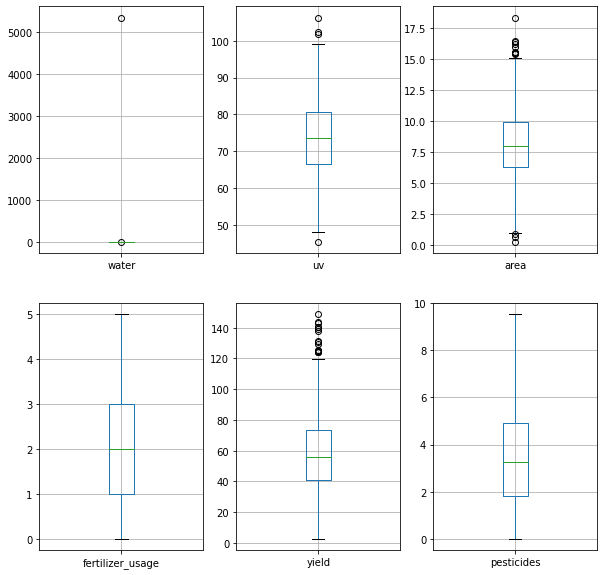

In [21]:
# Plot boxplots
plt.figure(figsize=(10,10))
for i in range(len(data.describe().columns[1:])):
    plt.subplot(2,3,i+1)
    pd.DataFrame(data2.loc[:,data.describe().columns[i]]).boxplot()

Water seems to have a severe outlier, I think it may be worth removing that observation

In [22]:
# Remove any values that have a water value of more than 1000
data3 = data2.loc[data2['water'] < 1000]

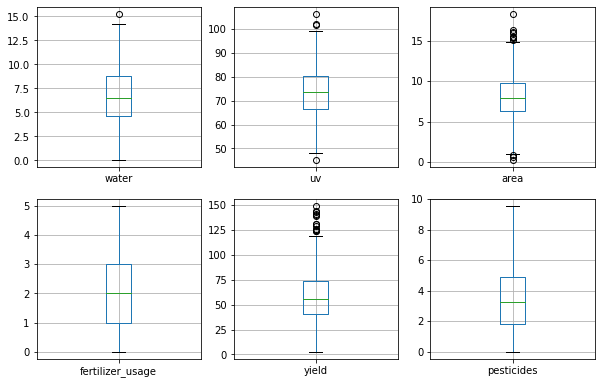

In [23]:
# Replot the boxplots
plt.figure(figsize=(10,10))
for i in range(len(data.describe().columns[1:])):
    plt.subplot(3,3,i+1)
    pd.DataFrame(data3.loc[:,data.describe().columns[i]]).boxplot()

Much better! Now let's tackle the issue of missing values. We will use an imputing method pre-packaged within sklearn called KNNImputer. By finding the two closest observations to an observation with a missing value, we can try to estimate the missing value. 

While NaN's are in particular tricky to work with, I think this is the lesser-of-all-evils (e.g. filling missing values with the mean or median of the rest of the column)

In [24]:
imputer = KNNImputer(n_neighbors=2)

In [25]:
data4 = pd.DataFrame(imputer.fit_transform(data3), columns=data3.columns)
data4.head()

,water,uv,area,fertilizer_usage,yield,pesticides,region,cat_a,cat_b,cat_c,cat_d
0,0.072,80.179,9.414,0.0,29.878,2.231,6.0,0.0,1.0,1.0,0.0
1,5.413,58.359,9.681,2.0,53.416,1.810,6.0,0.0,1.0,1.0,0.0
2,9.731,78.506,7.189,1.0,63.391,2.455,1.0,0.0,0.0,0.0,1.0
3,10.995,69.248,1.738,3.0,17.984,0.603,2.0,1.0,0.0,0.0,0.0
4,2.617,87.658,9.706,1.0,49.768,2.910,6.0,0.0,0.0,1.0,0.0


In [26]:
# Sanity Check, count number of NaNs in data4
data4.isna().sum()

water               0
uv                  0
area                0
fertilizer_usage    0
yield               0
pesticides          0
region              0
cat_a               0
cat_b               0
cat_c               0
cat_d               0
dtype: int64

In [27]:
data3

,water,uv,area,fertilizer_usage,yield,pesticides,region,cat_a,cat_b,cat_c,cat_d
0,0.072,80.179,9.414,0,29.878,2.231,6,0,1,1,0
1,5.413,58.359,9.681,2,53.416,1.810,6,0,1,1,0
2,9.731,78.506,7.189,1,63.391,2.455,1,0,0,0,1
3,10.995,69.248,1.738,3,17.984,0.603,2,1,0,0,0
4,2.617,87.658,9.706,1,49.768,2.910,6,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
995,5.457,70.622,8.163,3,89.809,4.224,2,0,0,1,0
996,6.931,75.326,5.675,0,29.261,1.355,2,1,1,0,1
997,10.373,78.225,7.378,3,76.608,5.459,2,0,1,0,0
998,9.158,79.257,9.011,2,80.399,5.968,1,1,1,1,1


# Model Building

Now, we will use this data to come up with a model. I think it's quite clear that **the variable we want to predict is total crop yield**. Farmers want to maximize the yield of their product subject to a number of constraints such as how much land they want to work with.

Generally, I like to start very simple with my models. If there is absolutely nothing to be found using a simple model, then chances are you will waste lots of time building a fancy model just for it to not work as well. For this reason, I will start with a simple multivariate regression. 

Let's divide our data into training and testing datasets:

In [28]:
# Separate dataframe into dependent and independent variables
X = data4.loc[:,data4.columns != 'yield']
y = data4.loc[:,'yield']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=9001)

## Model 1: Baseline Regression

In [30]:
# Fit the regression, print ANOVA table
est = sm.OLS(y_train, X_train)
lm = est.fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                  yield   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                              1323.
Date:                Thu, 09 Sep 2021   Prob (F-statistic):                        0.00
Time:                        13:09:29   Log-Likelihood:                         -2589.1
No. Observations:                 641   AIC:                                      5198.
Df Residuals:                     631   BIC:                                      5243.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

We can see here that the full model has some statistically significant results. For example, the $R^2$ is very high, and the p-values of many of the variables indicate that they are indeed strong. Furthermore, it is interesting to note that some of the pesticides appear to not be statistically significant i.e. category a and category d pesticides. Therefore, I'm keen to move forward and see if we can improve upon this. To get a baseline score, let's see the MSE of this linear model:

In [31]:
# Predict y_test values using model
y_pred_lm = lm.predict(X_test)

In [32]:
# Calculate the mean-squared error
mean_squared_error(y_test, y_pred_lm)

194.8634225375

This will be the score to beat! 

## Model 2: LASSO Regression

Since we saw that perhaps some of the variables in the linear model were not statistically significant, let's see if we can shrink any of the coefficients to zero and achieve a higher MSE score:

In [33]:
# Initialize a vanilla LASSO regression
lreg = linear_model.Lasso(alpha=0.1)

# Fit the model
lasso = lreg.fit(X_train, y_train)

In [34]:
# Predict y_test values
y_pred_lasso = lasso.predict(X_test)

In [35]:
# Calculate MSE
mean_squared_error(y_test, y_pred_lasso)

190.29940128747336

This is good and all, but perhaps we should do some cross validation on our alpha to see if we can do even better. 

In [36]:
# Initialize array of alphas
alphas = np.linspace(0,5,51)

In [37]:
# Loop through each alpha
res = []
for alpha in alphas:
    
    # Split training data into smaller training/validation sets
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.33, random_state=9002)
    
    # Train the model on new training data
    lreg = linear_model.Lasso(alpha=alpha)
    lasso = lreg.fit(X_train2, y_train2)
    
    # Predict the values of the validation data
    y_pred_lasso = lasso.predict(X_test2)
    
    # Append MSE
    res.append([alpha, mean_squared_error(y_test2, y_pred_lasso)])

/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38107.47872868374, tolerance: 25.28827263313007
  positive)


We managed to beat the vanilla linear model, which is great. Now, let's try to find the alpha that gives us the most promising results:

<AxesSubplot:xlabel='$\\alpha$'>

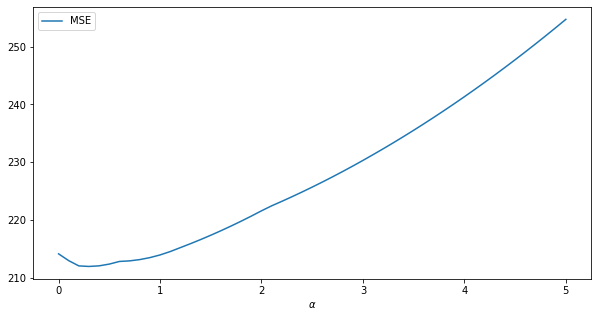

In [38]:
# Plot the MSE of the models using various alphas
lasso_cv_res = pd.DataFrame(res, columns=[r'$\alpha$', 'MSE']).set_index(r'$\alpha$')
lasso_cv_res.plot(figsize=(10,5))

In [39]:
# Find the minimum of this graph
lasso_cv_res.loc[(lasso_cv_res == lasso_cv_res.min()).values]

,MSE
$\alpha$,
0.3,211.918152


Our best value is when $\alpha = 0.3$. Let's see how this compares to our other results:

In [40]:
# Fit the model with alpha=0.3
lreg = linear_model.Lasso(alpha=0.3)
lasso = lreg.fit(X_train, y_train)

In [41]:
# Predict y_test using this final model
y_pred_lasso = lasso.predict(X_test)

In [42]:
# Print MSE
mean_squared_error(y_test, y_pred_lasso)

188.40524682905476

This is the best score we've seen thus far! Finally, let's move onto an even fancier model: Random Forests.

## Model 3: Random Forests

Random forests are exceptionally good at these types of problems. 

In [43]:
# Initialize vanilla Random Forests model
regressor = RandomForestRegressor(n_estimators = 100, random_state = 9003)

In [44]:
# Fit using training data
regressor.fit(X_train, y_train)  

RandomForestRegressor(random_state=9003)

In [45]:
# Predict y_test using vanilla RF
y_pred_rf = regressor.predict(X_test)

In [46]:
# Print MSE
mean_squared_error(y_test, y_pred_rf)

101.37431094347754

This just about blows the other models out of the water using only vanilla parameters. Let's see if we can improve on it even further by doing some cross validation. Let's first define the parameters of our CV grid search:

In [47]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [48]:
# Create our grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [49]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=9003, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 73, 126, 180, 233,
                                                         286, 340, 393, 446,
                                                         500]},
                   random_state=9003, verbose=2)

In [50]:
rf_random.best_params_

{'n_estimators': 446,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

In [51]:
best_random = rf_random.best_estimator_

In [52]:
mean_squared_error(y_test, best_random.predict(X_test))

101.76442450135019

Even though this model does not have as low MSE as the vanilla RF model, I think sacrificing a bit of error for the sake of robustness is worth it. For this reason, I would be going with this model as my final model. 

# Next Steps

For next steps, I would want to use this model to nowcast the expected yield of a farm as data rolls in. This information can be used in a variety of ways including creating a signal to trade futures contracts on specific crop based on the expected combined yield of farms growing that crop. Low yield indicates low supply which means prices will generally be higher. 

We can also use this model to assist farmers in maximixing yield given certain conditions, or give them an idea of what to expect for yield.